##### Copyright 2021 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Variational Inference on Probabilistic Graphical Models with Joint Distributions

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/Variational_Inference_and_Joint_Distributions"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Variational_Inference_and_Joint_Distributions.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Variational_Inference_and_Joint_Distributions.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/Variational_Inference_and_Joint_Distributions.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Variational Inference (VI) casts approximate Bayesian inference as an optimization problem and seeks a 'surrogate' posterior distribution that minimizes the KL divergence with the true posterior. Gradient-based VI is often faster than MCMC methods, composes naturally with optimization of model parameters, and provides a lower bound on model evidence that can be used directly for model comparison, convergence diagnosis, and composable inference.

TensorFlow Probability offers tools for fast, flexible, and scalable VI that fit naturally into the TFP stack. These tools enable the construction of surrogate posteriors with covariance structures induced by linear transformations or normalizing flows.

VI can be used to estimate Bayesian [credible intervals](https://en.wikipedia.org/wiki/Credible_interval) for parameters of a regression model to estimate the effects of various treatments or observed features on an outcome of interest. Credible intervals bound the values of an unobserved parameter with a certain probability, according to the posterior distribution of the parameter conditioned on observed data and given an assumption on the parameter's prior distribution.

In this Colab, we demonstrate how to use VI to obtain credible intervals for parameters of a Bayesian linear regression model for radon levels measured in homes (using [Gelman et al.'s (2007) Radon dataset](http://www.stat.columbia.edu/~gelman/arm/); see [similar examples](https://mc-stan.org/users/documentation/case-studies/radon.html#Correlations-among-levels) in Stan). We demonstrate how TFP `JointDistribution`s combine with `bijectors` to build and fit two types of expressive surrogate posteriors:

- a standard Normal distribution transformed by a block matrix.  The matrix may reflect independence among some components of the posterior and dependence among others, relaxing the assumption of a mean-field or full-covariance posterior.
- a more complex, higher-capacity [inverse autoregressive flow](https://arxiv.org/abs/1606.04934).

The surrogate posteriors are trained and compared with results from a mean-field surrogate posterior baseline, as well as ground-truth samples from Hamiltonian Monte Carlo.

## Overview of Bayesian Variational Inference

Suppose we have the following generative process, where $\theta$ represents random parameters, $\omega$ represents deterministic parameters, and the $x_i$ are features and the $y_i$ are target values for $i=1,\ldots,n$ observed data points:
\begin{align*}
&\theta \sim r(\Theta) && \text{(Prior)}\\
&\text{for } i = 1 \ldots n: \nonumber \\
&\quad y_i \sim p(Y_i|x_i, \theta, \omega) && \text{(Likelihood)}
\end{align*}

VI is then characterized by:
$\newcommand{\E}{\operatorname{\mathbb{E}}}
\newcommand{\K}{\operatorname{\mathbb{K}}}
\newcommand{\defeq}{\overset{\tiny\text{def}}{=}}
\DeclareMathOperator*{\argmin}{arg\,min}$

\begin{align*}
-\log p(\{y_i\}_i^n|\{x_i\}_i^n, \omega)
&\defeq -\log \int \textrm{d}\theta\, r(\theta) \prod_i^n p(y_i|x_i,\theta, \omega) && \text{(Really hard integral)} \\
&= -\log \int \textrm{d}\theta\, q(\theta) \frac{1}{q(\theta)} r(\theta) \prod_i^n p(y_i|x_i,\theta, \omega) && \text{(Multiply by 1)}\\
&\le - \int \textrm{d}\theta\, q(\theta) \log \frac{r(\theta) \prod_i^n p(y_i|x_i,\theta, \omega)}{q(\theta)}  && \text{(Jensen's inequality)}\\
&\defeq \E_{q(\Theta)}[ -\log p(y_i|x_i,\Theta, \omega) ] + \K[q(\Theta), r(\Theta)]\\
&\defeq ``\text{expected negative log likelihood"} + ``\text{kl regularizer"}
\end{align*}

(Technically we're assuming $q$ is [absolutely continuous](https://en.wikipedia.org/wiki/Absolute_continuity#Absolute_continuity_of_measures) with respect to $r$. See also, [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality).)

Since the bound holds for all q, it is obviously tightest for:

$$q^*,w^* = \argmin_{q \in \mathcal{Q},\omega\in\mathbb{R}^d} \left\{ \sum_i^n\E_{q(\Theta)}\left[ -\log p(y_i|x_i,\Theta, \omega) \right] + \K[q(\Theta), r(\Theta)] \right\}$$




Regarding terminology, we call

- $q^*$ the "surrogate posterior," and,
- $\mathcal{Q}$ the "surrogate family."

$\omega^*$ represents the maximum-likelihood values of the deterministic parameters on the VI loss. See [this survey](https://arxiv.org/abs/1601.00670) for more information on variational inference.

## Example: Bayesian hierarchical linear regression on Radon measurements

Radon is a radioactive gas that enters homes through contact points with the
ground. It is a carcinogen that is the primary cause of lung cancer in
non-smokers. Radon levels vary greatly from household to household.

The EPA did a study of radon levels in 80,000 houses. Two important predictors
are:
- Floor on which the measurement was taken (radon higher in basements)
- County uranium level (positive correlation with radon levels)

Predicting radon levels in houses grouped by county is a classic problem in Bayesian hierarchical modeling, introduced by [Gelman and Hill (2006)](http://www.stat.columbia.edu/~gelman/arm/). We will build a hierarchical linear model to predict radon measurements in houses, in which the hierarchy is the grouping of houses by county. We are interested in credible intervals for the effect of location (county) on the radon level of houses in Minnesota. In order to isolate this effect, the effects of floor and uranium level are also included in the model. Additionally, we will incorporate a contextual effect corresponding to the mean floor on which the measurement was taken, by county, so that if there is variation among counties of the floor on which the measurements were taken, this is not attributed to the county effect.

In [12]:
!pip install ml-dtypes~=0.2.0
# !pip install tensorflow tensorflow-probability
!pip install --upgrade tensorflow tensorflow-probability


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import tf_keras
import tensorflow_probability as tfp
import warnings

tfd = tfp.distributions
tfb = tfp.bijectors

plt.rcParams['figure.facecolor'] = '1.'

In [3]:
# Load the Radon dataset from `tensorflow_datasets` and filter to data from
# Minnesota.
dataset = tfds.as_numpy(
    tfds.load('radon', split='train').filter(
        lambda x: x['features']['state'] == 'MN').batch(10**9))

# Dependent variable: Radon measurements by house.
dataset = next(iter(dataset))
radon_measurement = dataset['activity'].astype(np.float32)
radon_measurement[radon_measurement <= 0.] = 0.1
log_radon = np.log(radon_measurement)

# Measured uranium concentrations in surrounding soil.
uranium_measurement = dataset['features']['Uppm'].astype(np.float32)
log_uranium = np.log(uranium_measurement)

# County indicator.
county_strings = dataset['features']['county'].astype('U13')
unique_counties, county = np.unique(county_strings, return_inverse=True)
county = county.astype(np.int32)
num_counties = unique_counties.size

# Floor on which the measurement was taken.
floor_of_house = dataset['features']['floor'].astype(np.int32)

# Average floor by county (contextual effect).
county_mean_floor = []
for i in range(num_counties):
  county_mean_floor.append(floor_of_house[county == i].mean())
county_mean_floor = np.array(county_mean_floor, dtype=log_radon.dtype)
floor_by_county = county_mean_floor[county]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12573 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/radon/1.0.0.incomplete3E3609/radon-train.tfrecord*...:   0%|          | 0/…

Dataset radon downloaded and prepared to /root/tensorflow_datasets/radon/1.0.0. Subsequent calls will reuse this data.


The regression model is specified as follows:

$\newcommand{\Normal}{\operatorname{\sf Normal}}$
\begin{align*}
&\text{uranium_weight}  \sim \Normal(0, 1) \\
&\text{county_floor_weight}  \sim \Normal(0, 1) \\
&\text{for } j = 1\ldots \text{num_counties}:\\
&\quad \text{county_effect}_j  \sim \Normal (0, \sigma_c)\\
&\text{for } i = 1\ldots n:\\
&\quad \mu_i  = ( \\
&\quad\quad \text{bias} \\
&\quad\quad + \text{county_effect}_{\text{county}_i}  \\
&\quad\quad +\text{log_uranium}_i \times  \text{uranium_weight} \\
&\quad\quad +\text{floor_of_house}_i \times \text{floor_weight} \\
&\quad\quad +\text{floor_by_county}_{\text{county}_i} \times \text{county_floor_weight} ) \\
&\quad \text{log_radon}_i  \sim \Normal(\mu_i, \sigma_y)
\end{align*}
in which $i$ indexes the observations and $\text{county}_i$ is the county in which the $i$th observation was taken.

We use a county-level random effect to capture geographical variation. The parameters `uranium_weight` and `county_floor_weight` are modeled probabilistically, and `floor_weight` and the constant `bias` are deterministic.  These modeling choices are largely arbitrary, and are made for the purpose of demonstrating VI on a probabilistic model of reasonable complexity. For a more thorough discussion of multilevel modeling with fixed and random effects in TFP, using the radon dataset, see [Multilevel Modeling Primer](https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Multilevel_Modeling_Primer.ipynb) and [Fitting Generalized Linear Mixed-effects Models Using Variational Inference](https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Linear_Mixed_Effects_Model_Variational_Inference.ipynb).

In [4]:
# Create variables for fixed effects.
floor_weight = tf.Variable(0.)
bias = tf.Variable(0.)

# Variables for scale parameters.
log_radon_scale = tfp.util.TransformedVariable(1., tfb.Exp())
county_effect_scale = tfp.util.TransformedVariable(1., tfb.Exp())

# Define the probabilistic graphical model as a JointDistribution.
@tfd.JointDistributionCoroutineAutoBatched
def model():
  uranium_weight = yield tfd.Normal(0., scale=1., name='uranium_weight')
  county_floor_weight = yield tfd.Normal(
      0., scale=1., name='county_floor_weight')
  county_effect = yield tfd.Sample(
      tfd.Normal(0., scale=county_effect_scale),
      sample_shape=[num_counties], name='county_effect')
  yield tfd.Normal(
      loc=(log_uranium * uranium_weight + floor_of_house* floor_weight
           + floor_by_county * county_floor_weight
           + tf.gather(county_effect, county, axis=-1)
           + bias),
      scale=log_radon_scale[..., tf.newaxis],
      name='log_radon')

# Pin the observed `log_radon` values to model the un-normalized posterior.
target_model = model.experimental_pin(log_radon=log_radon)

## Expressive surrogate posteriors

Next we estimate the posterior distributions of the random effects using VI with two different types of surrogate posteriors:
- A constrained multivariate Normal distribution, with covariance structure induced by a blockwise matrix transformation.
- A multivariate Standard Normal distribution transformed by an [Inverse Autoregressive Flow](https://arxiv.org/abs/1606.04934), which is then split and restructured to match the support of the posterior.

### Multivariate Normal surrogate posterior

To build this surrogate posterior, a trainable linear operator is used to induce correlation among the components of the posterior.

In [5]:
# Determine the `event_shape` of the posterior, and calculate the size of each
# `event_shape` component. These determine the sizes of the components of the
# underlying standard Normal distribution, and the dimensions of the blocks in
# the blockwise matrix transformation.
event_shape = target_model.event_shape_tensor()
flat_event_shape = tf.nest.flatten(event_shape)
flat_event_size = tf.nest.map_structure(tf.reduce_prod, flat_event_shape)

# The `event_space_bijector` maps unconstrained values (in R^n) to the support
# of the prior -- we'll need this at the end to constrain Multivariate Normal
# samples to the prior's support.
event_space_bijector = target_model.experimental_default_event_space_bijector()

Construct a `JointDistribution` with vector-valued standard Normal components, with sizes determined by the corresponding prior components. The components should be vector-valued so they can be transformed by the linear operator.

In [6]:
base_standard_dist = tfd.JointDistributionSequential(
      [tfd.Sample(tfd.Normal(0., 1.), s) for s in flat_event_size])

Build a trainable blockwise lower-triangular linear operator. We'll apply it to the standard Normal distribution to implement a (trainable) blockwise matrix transformation and induce the correlation structure of the posterior.

Within the blockwise linear operator, a trainable full-matrix block represents full covariance between two components of the posterior, while a block of zeros (or `None`) expresses independence. Blocks on the diagonal are either lower-triangular or diagonal matrices, so that the entire block structure represents a lower-triangular matrix.

Applying this bijector to the base distribution results in a multivariate Normal distribution with mean 0 and (Cholesky-factored) covariance equal to the lower-triangular block matrix.

In [7]:
operators = (
    (tf.linalg.LinearOperatorDiag,),  # Variance of uranium weight (scalar).
    (tf.linalg.LinearOperatorFullMatrix,  # Covariance between uranium and floor-by-county weights.
     tf.linalg.LinearOperatorDiag),  # Variance of floor-by-county weight (scalar).
    (None,  # Independence between uranium weight and county effects.
     None,  #  Independence between floor-by-county and county effects.
     tf.linalg.LinearOperatorDiag)  # Independence among the 85 county effects.
    )

block_tril_linop = (
    tfp.experimental.vi.util.build_trainable_linear_operator_block(
        operators, flat_event_size))
scale_bijector = tfb.ScaleMatvecLinearOperatorBlock(block_tril_linop)

After applying the linear operator to the standard Normal distribution, apply a multipart `Shift` bijector to allow the mean to take nonzero values.

In [8]:
loc_bijector = tfb.JointMap(
    tf.nest.map_structure(
        lambda s: tfb.Shift(
            tf.Variable(tf.random.uniform(
                (s,), minval=-2., maxval=2., dtype=tf.float32))),
        flat_event_size))

The resulting multivariate Normal distribution, obtained by transforming the standard Normal distribution with the scale and location bijectors, must be reshaped and restructured to match the prior, and finally constrained to the support of the prior.

In [9]:
# Reshape each component to match the prior, using a nested structure of
# `Reshape` bijectors wrapped in `JointMap` to form a multipart bijector.
reshape_bijector = tfb.JointMap(
    tf.nest.map_structure(tfb.Reshape, flat_event_shape))

# Restructure the flat list of components to match the prior's structure
unflatten_bijector = tfb.Restructure(
        tf.nest.pack_sequence_as(
            event_shape, range(len(flat_event_shape))))

Now, put it all together -- chain the trainable bijectors together and apply them to the base standard Normal distribution to construct the surrogate posterior.

In [10]:
surrogate_posterior = tfd.TransformedDistribution(
    base_standard_dist,
    bijector = tfb.Chain(  # Note that the chained bijectors are applied in reverse order
        [
         event_space_bijector,  # constrain the surrogate to the support of the prior
         unflatten_bijector,  # pack the reshaped components into the `event_shape` structure of the posterior
         reshape_bijector,  # reshape the vector-valued components to match the shapes of the posterior components
         loc_bijector,  # allow for nonzero mean
         scale_bijector  # apply the block matrix transformation to the standard Normal distribution
         ]))

Train the multivariate Normal surrogate posterior.

Multivariate Normal surrogate posterior ELBO: -1065.67919921875


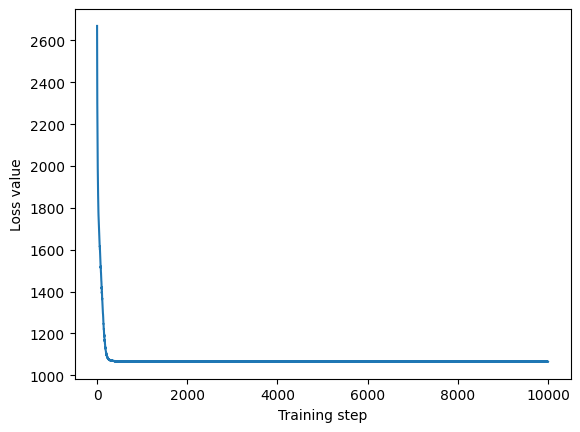

In [11]:
optimizer = tf_keras.optimizers.Adam(learning_rate=1e-2)
mvn_loss = tfp.vi.fit_surrogate_posterior(
    target_model.unnormalized_log_prob,
    surrogate_posterior,
    optimizer=optimizer,
    num_steps=10**4,
    sample_size=16,
    jit_compile=True)

mvn_samples = surrogate_posterior.sample(1000)
mvn_final_elbo = tf.reduce_mean(
    target_model.unnormalized_log_prob(*mvn_samples)
    - surrogate_posterior.log_prob(mvn_samples))

print('Multivariate Normal surrogate posterior ELBO: {}'.format(mvn_final_elbo))

plt.plot(mvn_loss)
plt.xlabel('Training step')
_ = plt.ylabel('Loss value')

Since the trained surrogate posterior is a TFP distribution, we can take samples from it and process them to produce posterior credible intervals for the parameters.

The box-and-whiskers plots below show 50% and 95% [credible intervals](https://en.wikipedia.org/wiki/Credible_interval) for the county effect of the two largest counties and the regression weights on soil uranium measurements and mean floor by county. The posterior credible intervals for county effects indicate that location in St. Louis county is associated with lower radon levels, after accounting for other variables, and that the effect of location in Hennepin county is near neutral.

Posterior credible intervals on the regression weights show that higher levels of soil uranium are associated with higher radon levels, and counties where measurements were taken on higher floors (likely because the house didn't have a basement) tend to have higher levels of radon, which could relate to soil properties and their effect on the type of structures built.

The (deterministic) coefficient of floor is negative, indicating that lower floors have higher radon levels, as expected.

Bias is: 1.39
Floor fixed effect is: -0.73


<ipython-input-12-0b15493b7bc2>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(list(var_results.keys()), fontsize=fs)
<ipython-input-12-0b15493b7bc2>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(list(var_results.keys()), fontsize=fs)
<ipython-input-12-0b15493b7bc2>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(list(var_results.keys()), fontsize=fs)
<ipython-input-12-0b15493b7bc2>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(list(var_results.keys()), fontsize=fs)


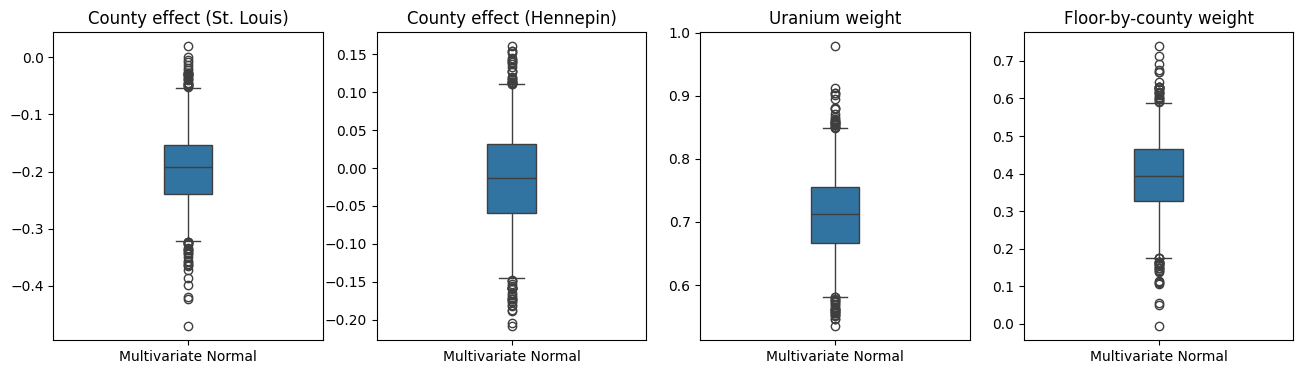

In [12]:
st_louis_co = 69  # Index of St. Louis, the county with the most observations.
hennepin_co = 25  # Index of Hennepin, with the second-most observations.

def pack_samples(samples):
  return {'County effect (St. Louis)': samples.county_effect[..., st_louis_co],
          'County effect (Hennepin)': samples.county_effect[..., hennepin_co],
          'Uranium weight': samples.uranium_weight,
          'Floor-by-county weight': samples.county_floor_weight}

def plot_boxplot(posterior_samples):
  fig, axes = plt.subplots(1, 4, figsize=(16, 4))

  # Invert the results dict for easier plotting.
  k = list(posterior_samples.values())[0].keys()
  plot_results = {
      v: {p: posterior_samples[p][v] for p in posterior_samples} for v in k}
  for i, (var, var_results) in enumerate(plot_results.items()):
    sns.boxplot(data=list(var_results.values()), ax=axes[i],
                width=0.18*len(var_results), whis=(2.5, 97.5))
    # axes[i].boxplot(list(var_results.values()), whis=(2.5, 97.5))
    axes[i].title.set_text(var)
    fs = 10 if len(var_results) < 4 else 8
    axes[i].set_xticklabels(list(var_results.keys()), fontsize=fs)

results = {'Multivariate Normal': pack_samples(mvn_samples)}

print('Bias is: {:.2f}'.format(bias.numpy()))
print('Floor fixed effect is: {:.2f}'.format(floor_weight.numpy()))
plot_boxplot(results)

### Inverse Autoregressive Flow surrogate posterior

Inverse Autoregressive Flows (IAFs) are normalizing flows that use neural networks to capture complex, nonlinear dependencies among components of the distribution. Next we build an IAF surrogate posterior to see whether this higher-capacity, more flexible model outperforms the constrained multivariate Normal.

In [13]:
# Build a standard Normal with a vector `event_shape`, with length equal to the
# total number of degrees of freedom in the posterior.
base_distribution = tfd.Sample(
    tfd.Normal(0., 1.), sample_shape=[tf.reduce_sum(flat_event_size)])

# Apply an IAF to the base distribution.
num_iafs = 2
iaf_bijectors = [
    tfb.Invert(tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, hidden_units=[256, 256], activation='relu')))
    for _ in range(num_iafs)
]

# Split the base distribution's `event_shape` into components that are equal
# in size to the prior's components.
split = tfb.Split(flat_event_size)

# Chain these bijectors and apply them to the standard Normal base distribution
# to build the surrogate posterior. `event_space_bijector`,
# `unflatten_bijector`, and `reshape_bijector` are the same as in the
# multivariate Normal surrogate posterior.
iaf_surrogate_posterior = tfd.TransformedDistribution(
    base_distribution,
    bijector=tfb.Chain([
         event_space_bijector,  # constrain the surrogate to the support of the prior
         unflatten_bijector,  # pack the reshaped components into the `event_shape` structure of the prior
         reshape_bijector,  # reshape the vector-valued components to match the shapes of the prior components
         split] +  # Split the samples into components of the same size as the prior components
         iaf_bijectors  # Apply a flow model to the Tensor-valued standard Normal distribution
         ))

Train the IAF surrogate posterior.

IAF surrogate posterior ELBO: -1065.5992431640625


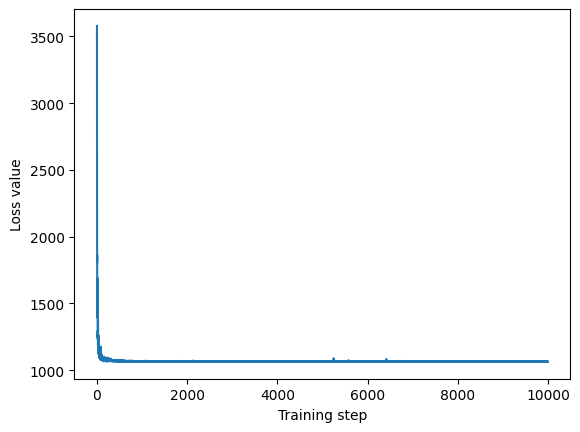

In [14]:
optimizer=tf_keras.optimizers.Adam(learning_rate=1e-2)
iaf_loss = tfp.vi.fit_surrogate_posterior(
  target_model.unnormalized_log_prob,
  iaf_surrogate_posterior,
  optimizer=optimizer,
  num_steps=10**4,
  sample_size=4,
  jit_compile=True)

iaf_samples = iaf_surrogate_posterior.sample(1000)
iaf_final_elbo = tf.reduce_mean(
    target_model.unnormalized_log_prob(*iaf_samples)
    - iaf_surrogate_posterior.log_prob(iaf_samples))
print('IAF surrogate posterior ELBO: {}'.format(iaf_final_elbo))

plt.plot(iaf_loss)
plt.xlabel('Training step')
_ = plt.ylabel('Loss value')

The credible intervals for the IAF surrogate posterior appear similar to those of the constrained multivariate Normal.

<ipython-input-12-0b15493b7bc2>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(list(var_results.keys()), fontsize=fs)
<ipython-input-12-0b15493b7bc2>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(list(var_results.keys()), fontsize=fs)
<ipython-input-12-0b15493b7bc2>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(list(var_results.keys()), fontsize=fs)
<ipython-input-12-0b15493b7bc2>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(list(var_results.keys()), fontsize=fs)


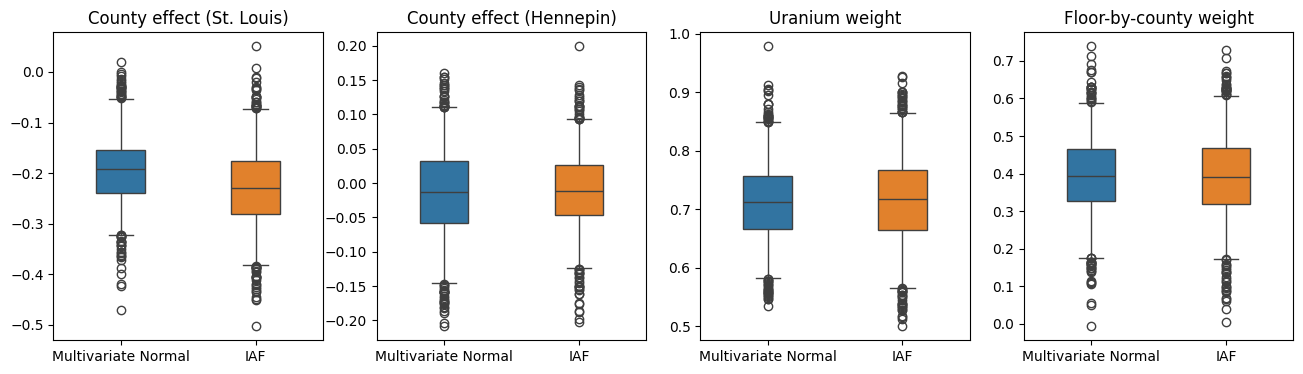

In [15]:
results['IAF'] = pack_samples(iaf_samples)
plot_boxplot(results)

### Baseline: Mean-field surrogate posterior

VI surrogate posteriors are often assumed to be mean-field (independent) Normal distributions, with trainable means and variances, that are constrained to the support of the prior with a bijective transformation. We define a mean-field surrogate posterior in addition to the two more expressive surrogate posteriors, using the same general formula as the multivariate Normal surrogate posterior.

Mean-field surrogate posterior ELBO: -1065.664794921875


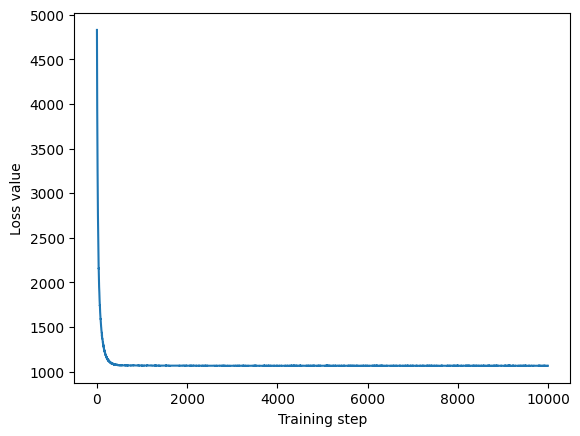

In [16]:
# A block-diagonal linear operator, in which each block is a diagonal operator,
# transforms the standard Normal base distribution to produce a mean-field
# surrogate posterior.
operators = (tf.linalg.LinearOperatorDiag,
             tf.linalg.LinearOperatorDiag,
             tf.linalg.LinearOperatorDiag)
block_diag_linop = (
    tfp.experimental.vi.util.build_trainable_linear_operator_block(
        operators, flat_event_size))
mean_field_scale = tfb.ScaleMatvecLinearOperatorBlock(block_diag_linop)

mean_field_loc = tfb.JointMap(
    tf.nest.map_structure(
        lambda s: tfb.Shift(
            tf.Variable(tf.random.uniform(
                (s,), minval=-2., maxval=2., dtype=tf.float32))),
        flat_event_size))

mean_field_surrogate_posterior = tfd.TransformedDistribution(
    base_standard_dist,
    bijector = tfb.Chain(  # Note that the chained bijectors are applied in reverse order
        [
         event_space_bijector,  # constrain the surrogate to the support of the prior
         unflatten_bijector,  # pack the reshaped components into the `event_shape` structure of the posterior
         reshape_bijector, # reshape the vector-valued components to match the shapes of the posterior components
         mean_field_loc,   # allow for nonzero mean
         mean_field_scale  # apply the block matrix transformation to the standard Normal distribution
         ]))

optimizer=tf_keras.optimizers.Adam(learning_rate=1e-2)
mean_field_loss = tfp.vi.fit_surrogate_posterior(
    target_model.unnormalized_log_prob,
    mean_field_surrogate_posterior,
    optimizer=optimizer,
    num_steps=10**4,
    sample_size=16,
    jit_compile=True)

mean_field_samples = mean_field_surrogate_posterior.sample(1000)
mean_field_final_elbo = tf.reduce_mean(
    target_model.unnormalized_log_prob(*mean_field_samples)
    - mean_field_surrogate_posterior.log_prob(mean_field_samples))
print('Mean-field surrogate posterior ELBO: {}'.format(mean_field_final_elbo))

plt.plot(mean_field_loss)
plt.xlabel('Training step')
_ = plt.ylabel('Loss value')

In this case, the mean field surrogate posterior gives similar results to the more expressive surrogate posteriors, indicating that this simpler model may be adequate for the inference task.

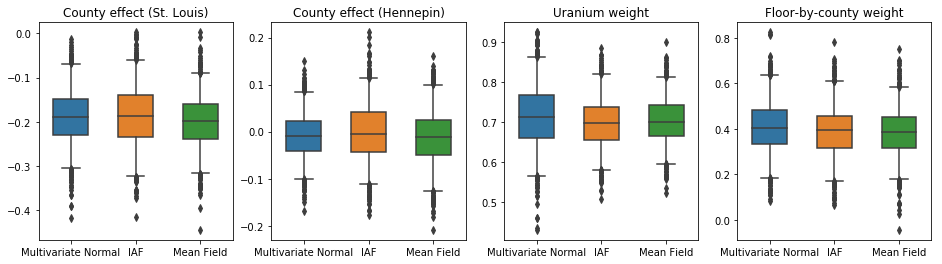

In [ ]:
results['Mean Field'] = pack_samples(mean_field_samples)
plot_boxplot(results)

### Ground truth: Hamiltonian Monte Carlo (HMC)

We use HMC to generate "ground truth" samples from the true posterior, for comparison with results of the surrogate posteriors.

In [17]:
num_chains = 8
num_leapfrog_steps = 3
step_size = 0.4
num_steps=20000

flat_event_shape = tf.nest.flatten(target_model.event_shape)
enum_components = list(range(len(flat_event_shape)))
bijector = tfb.Restructure(
    enum_components,
    tf.nest.pack_sequence_as(target_model.event_shape, enum_components))(
        target_model.experimental_default_event_space_bijector())

current_state = bijector(
    tf.nest.map_structure(
        lambda e: tf.zeros([num_chains] + list(e), dtype=tf.float32),
    target_model.event_shape))

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_model.unnormalized_log_prob,
    num_leapfrog_steps=num_leapfrog_steps,
    step_size=[tf.fill(s.shape, step_size) for s in current_state])

hmc = tfp.mcmc.TransformedTransitionKernel(
    hmc, bijector)
hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
    hmc,
    num_adaptation_steps=int(num_steps // 2 * 0.8),
    target_accept_prob=0.9)

chain, is_accepted = tf.function(
    lambda current_state: tfp.mcmc.sample_chain(
        current_state=current_state,
        kernel=hmc,
        num_results=num_steps // 2,
        num_burnin_steps=num_steps // 2,
        trace_fn=lambda _, pkr:
        (pkr.inner_results.inner_results.is_accepted),
        ),
    autograph=False,
    jit_compile=True)(current_state)

accept_rate = tf.reduce_mean(tf.cast(is_accepted, tf.float32))
ess = tf.nest.map_structure(
    lambda c: tfp.mcmc.effective_sample_size(
        c,
        cross_chain_dims=1,
        filter_beyond_positive_pairs=True),
    chain)

r_hat = tf.nest.map_structure(tfp.mcmc.potential_scale_reduction, chain)
hmc_samples = pack_samples(
    tf.nest.pack_sequence_as(target_model.event_shape, chain))
print('Acceptance rate is {}'.format(accept_rate))

Acceptance rate is 0.9000499844551086


Plot sample traces to sanity-check HMC results.

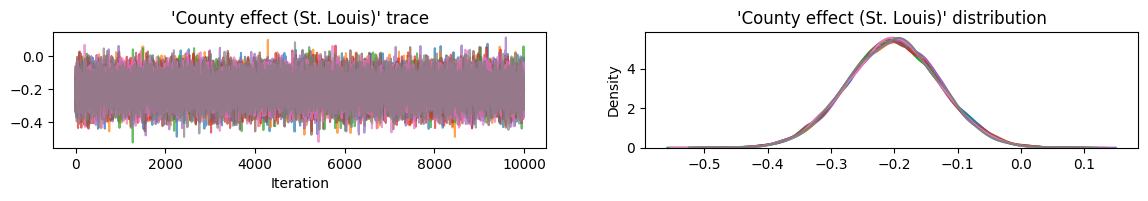

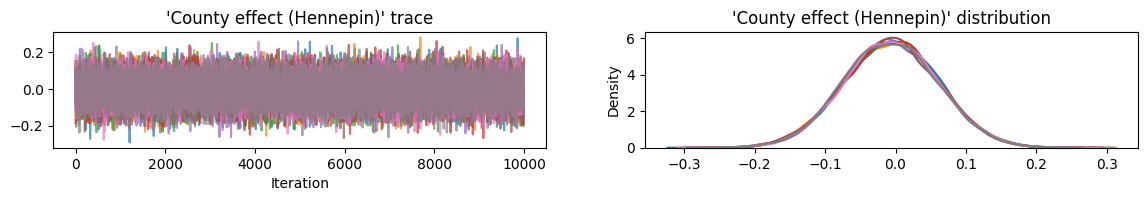

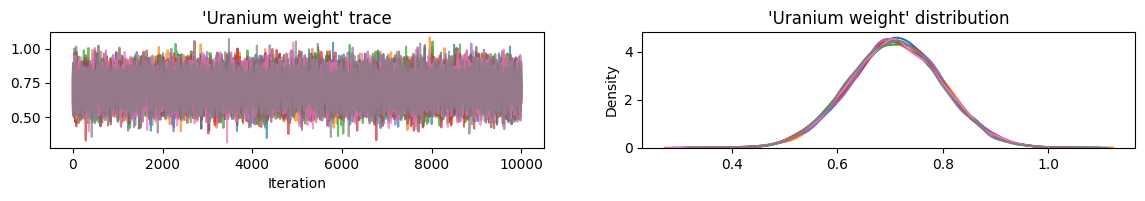

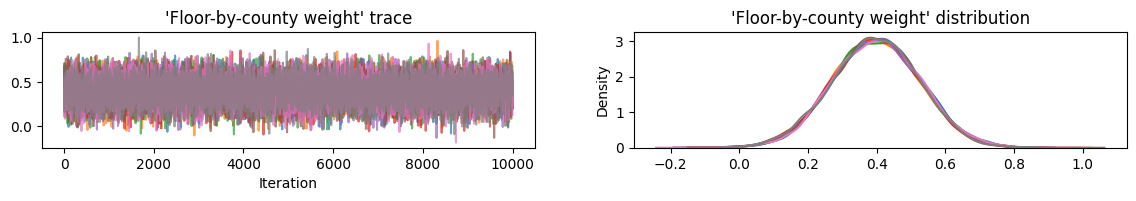

In [18]:
def plot_traces(var_name, samples):
  fig, axes = plt.subplots(1, 2, figsize=(14, 1.5), sharex='col', sharey='col')
  for chain in range(num_chains):
    s = samples.numpy()[:, chain]
    axes[0].plot(s, alpha=0.7)
    sns.kdeplot(s, ax=axes[1], shade=False)
    axes[0].title.set_text("'{}' trace".format(var_name))
    axes[1].title.set_text("'{}' distribution".format(var_name))
    axes[0].set_xlabel('Iteration')

warnings.filterwarnings('ignore')
for var, var_samples in hmc_samples.items():
  plot_traces(var, var_samples)

All three surrogate posteriors produced credible intervals that are visually similar to the HMC samples, though sometimes under-dispersed due to the effect of the ELBO loss, as is common in VI.

In [ ]:
results['HMC'] = hmc_samples
plot_boxplot(results)

## Additional results


In [26]:
#@title Plotting functions

plt.rcParams.update({'axes.titlesize': 'medium', 'xtick.labelsize': 'medium'})
def plot_loss_and_elbo():
  fig, axes = plt.subplots(1, 2, figsize=(12, 4))

  axes[0].scatter([0, 1, 2],
                  [mvn_final_elbo.numpy(),
                  iaf_final_elbo.numpy(),
                  mean_field_final_elbo.numpy()])
  axes[0].set_xticks(ticks=[0, 1, 2])
  axes[0].set_xticklabels(labels=[
    'Multivariate Normal', 'IAF', 'Mean Field'])
  axes[0].title.set_text('Evidence Lower Bound (ELBO)')

  axes[1].plot(mvn_loss, label='Multivariate Normal')
  axes[1].plot(iaf_loss, label='IAF')
  axes[1].plot(mean_field_loss, label='Mean Field')
  axes[1].set_ylim([1000, 4000])
  axes[1].set_xlabel('Training step')
  axes[1].set_ylabel('Loss (negative ELBO)')
  axes[1].title.set_text('Loss')
  plt.legend()
  plt.show()

plt.rcParams.update({'axes.titlesize': 'medium', 'xtick.labelsize': 'small'})
def plot_kdes(num_chains=8):
  fig, axes = plt.subplots(2, 2, figsize=(12, 8))
  k = list(results.values())[0].keys()
  plot_results = {
      v: {p: results[p][v] for p in results} for v in k}
  for i, (var, var_results) in enumerate(plot_results.items()):
    ax = axes[i % 2, i // 2]
    for posterior, posterior_results in var_results.items():
      if posterior == 'HMC':
        label = posterior
        for chain in range(num_chains):
          sns.kdeplot(
              posterior_results[:, chain],
              ax=ax, shade=False, color='k', linestyle=':', label=label)
          label=None
      else:
        sns.kdeplot(
            posterior_results, ax=ax, shade=False, label=posterior)
        ax.title.set_text('{}'.format(var))
    ax.legend()

### Evidence Lower Bound (ELBO)

IAF, by far the largest and most flexible surrogate posterior, converges to the highest Evidence Lower Bound (ELBO).

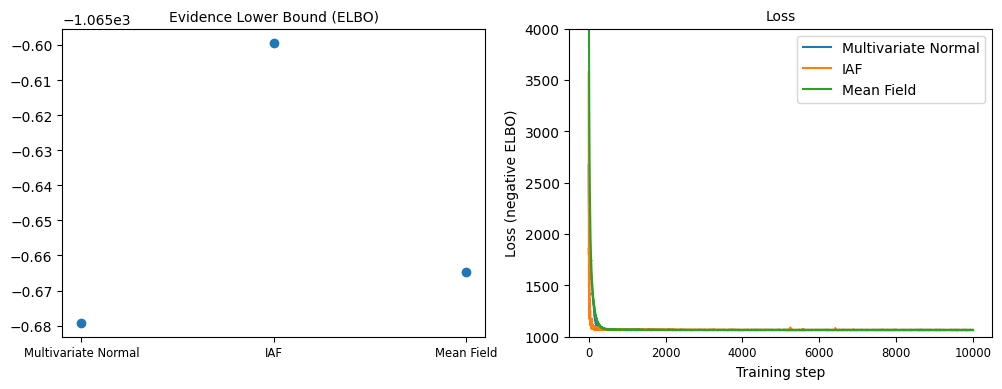

In [27]:
plot_loss_and_elbo()

### Posterior samples

Samples from each surrogate posterior, compared with HMC ground truth samples (a different visualization of the samples shown in the box plots).

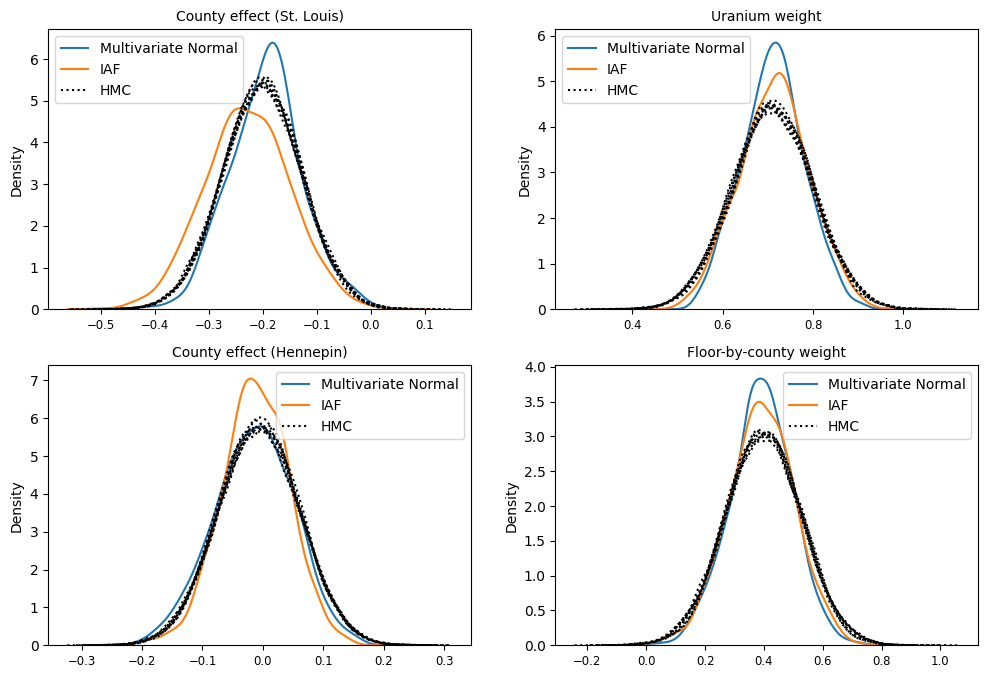

In [28]:
plot_kdes()

## Conclusion

In this Colab, we built VI surrogate posteriors using joint distributions and multipart bijectors, and fit them to estimate credible intervals for weights in a regression model on the radon dataset. For this simple model, more expressive surrogate posteriors performed similarly to a mean-field surrogate posterior. The tools we demonstrated, however, can be used to build a wide range of flexible surrogate posteriors suitable for more complex models.